## Telecom Churn Classification - Modeling
This notebook performs the following:<br/>
**Feature Assessment** <br/>
**Feature Engineering** <br/>
**Train/Test/Validation Split** <br/>
**Handling Class Imbalance** <br/>
**Modeling and Baseline** <br/>
**Hyperparameter Tuning & Model Comparison** <br/>
**Model Evaluation** <br/>
**Feature Importance Analysis** <br/>

In [1]:
#Import Libraries
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import stats
import pylab
from scipy.stats import shapiro, normaltest, skew, kurtosis
from scipy.stats import chi2_contingency
import itertools

import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import the data
df = pd.read_csv('churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Data preprocessing

In [6]:
# change the data type of MonthlyCharges from string to float
df['TotalCharges'] = df['TotalCharges'].replace(' ', 0).astype(float)
print('dtype of Total Charges is:', df['TotalCharges'].dtype)
# drop CustomerID
df_cleaned = df.drop('customerID', axis=1)
df_cleaned.info()

dtype of Total Charges is: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  Payment

In [8]:
df_cleaned.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


In [10]:
# Check the avg value per Churn
def avg_value_by_churn(df, churn_col, cols):
    # Return the result so you can see it
    return df.groupby(churn_col)[cols].mean()

# For column selection, use a list, not df[]
cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
avg_value_by_churn(df_cleaned, 'Churn', cols)

,tenure,MonthlyCharges,TotalCharges
Churn,,,
No,37.569965,61.265124,2549.911442
Yes,17.979133,74.441332,1531.796094


In [12]:
# data type successfully got changed to float in the previous section!
# Since the minimum value was 18.25 from the initial exploration, I'm simply going to replce the 0 with the mean value
# 1: Calculate the mean of MonthlyCharges (excluding zeros)
monthly_charges_mean = df_cleaned[df_cleaned['MonthlyCharges'] != 0]['MonthlyCharges'].mean()

# 2: Replace 0s with the mean
df_cleaned['MonthlyCharges'] = df_cleaned['MonthlyCharges'].replace(0, monthly_charges_mean)

### Feature Assessment

#### Outlier detection

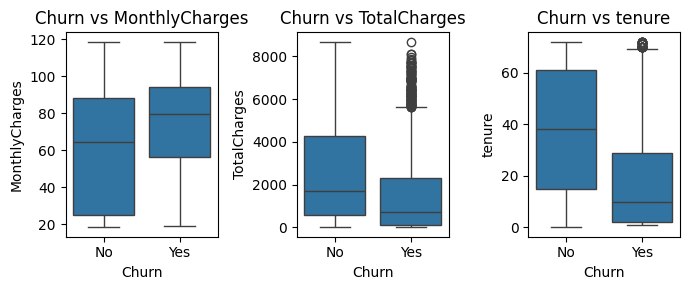

In [16]:
#Boxplot
# define the continuous variables you want to plot
df_con = df_cleaned[['MonthlyCharges', 'TotalCharges', 'tenure','Churn']]
continuous_vars = ['MonthlyCharges', 'TotalCharges', 'tenure']

# create subplots
# 1 row, 3 columns
fig, axes = plt.subplots(1, 3, figsize=(7, 3))  

# loop through variables and create a boxplot for each
for i, var in enumerate(continuous_vars):
    sns.boxplot(data=df, x='Churn', y=var, ax=axes[i])
    axes[i].set_title(f'Churn vs {var}')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

#### Class imbalance Assessment

In [19]:
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

# Define a plotting function for churn data
def plot_churn_data(X, y, title="Churn Class Distribution"):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Create a DataFrame for plotting
    df_plot = pd.DataFrame({
        'PCA1': X_pca[:, 0],
        'PCA2': X_pca[:, 1],
        'Churn': y.map({0: 'No Churn', 1: 'Churn'}) if isinstance(y, pd.Series) else pd.Series(y).map({0: 'No Churn', 1: 'Churn'})
    })

    plt.figure(figsize=(4, 3))
    sns.scatterplot(data=df_plot, x='PCA1', y='PCA2', hue='Churn', alpha=0.5, palette={'No Churn': 'blue', 'Churn': 'orange'})
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

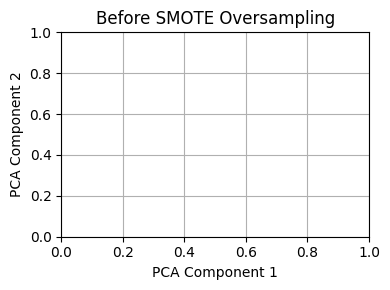

NameError: name 'X' is not defined

In [20]:
# convert original data to NumPy arrays
X_values = pd.get_dummies(df_cleaned.drop(columns='Churn'), drop_first=True)
y_values = df_cleaned['Churn']

# plot original class distribution
plot_churn_data(X_values, y_values, title="Before SMOTE Oversampling")

# apply SMOTE
smote = SMOTE(random_state=42, sampling_strategy=1.0)
X_resampled, y_resampled = smote.fit_resample(X, y)

# plot after oversampling
plot_churn_data(X_resampled.values, y_resampled.values, title="After SMOTE Oversampling")

#### Correlation Analysis

In [ ]:
# checking the correlation between the variables
from sklearn.preprocessing import LabelEncoder

# Copy the original dataframe to keep it safe
df_encoded = df_cleaned.copy()

# Get the list of non-numeric (text) columns
text_data_features = [col for col in df_encoded.columns if col not in df_encoded.describe().columns]

# Apply LabelEncoder to each text column
le = LabelEncoder()
print('Label Encoder Transformation')
for col in text_data_features:
    df_encoded[col] = le.fit_transform(df_encoded[col])
    print(f'{col} : {df_encoded[col].unique()} = {le.inverse_transform(df_encoded[col].unique())}')

In [23]:
# Calculate correlation matrix
correlation_matrix_all = df_encoded.corr()

# Create a heatmap
plt.figure(figsize=(24, 16))
sns.heatmap(correlation_matrix_all, annot=True, cmap='coolwarm', fmt='.2f',
            linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numeric Features', fontsize=16)
plt.tight_layout()
plt.show()

NameError: name 'df_encoded' is not defined

#### Chi-square tests for categorical variables

Chi-Square Test Results between Churn and Categorical Features:
             Feature   Chi-Square        P-Value  Degrees of Freedom  \
13          Contract  1184.596572  5.863038e-258                   2   
7     OnlineSecurity   849.998968  2.661150e-185                   2   
10       TechSupport   828.197068  1.443084e-180                   2   
6    InternetService   732.309590  9.571788e-160                   2   
15     PaymentMethod   648.142327  3.682355e-140                   3   
8       OnlineBackup   601.812790  2.079759e-131                   2   
9   DeviceProtection   558.419369  5.505219e-122                   2   
12   StreamingMovies   375.661479   2.667757e-82                   2   
11       StreamingTV   374.203943   5.528994e-82                   2   
14  PaperlessBilling   258.277649   4.073355e-58                   1   
3         Dependents   189.129249   4.924922e-43                   1   
2            Partner   158.733382   2.139911e-36                   1   


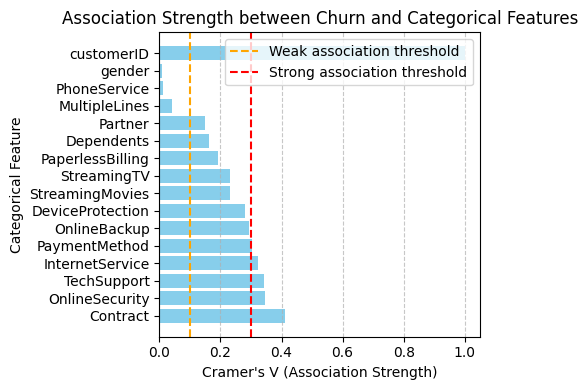

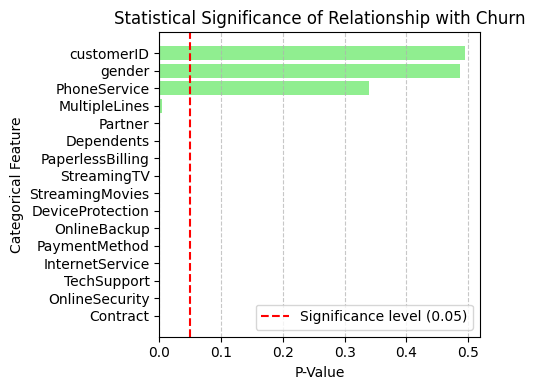


Categorical features significantly associated with Churn (p-value < 0.05):
             Feature        P-Value  Cramer's V
13          Contract  5.863038e-258    0.410116
7     OnlineSecurity  2.661150e-185    0.347400
10       TechSupport  1.443084e-180    0.342916
6    InternetService  9.571788e-160    0.322455
15     PaymentMethod  3.682355e-140    0.303359
8       OnlineBackup  2.079759e-131    0.292316
9   DeviceProtection  5.505219e-122    0.281580
12   StreamingMovies   2.667757e-82    0.230951
11       StreamingTV   5.528994e-82    0.230502
14  PaperlessBilling   4.073355e-58    0.191498
3         Dependents   4.924922e-43    0.163870
2            Partner   2.139911e-36    0.150126
5      MultipleLines   3.464383e-03    0.040109


In [26]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

# Function to perform chi-square test between Churn and other categorical variables
def chi_square_with_churn(df, categorical_cols, churn_col='Churn'):
    results = []
    
    # Ensure churn column isn't included in the loop comparisons
    other_cat_cols = [col for col in categorical_cols if col != churn_col]
    
    # Test relationship between Churn and each categorical feature
    for feature in other_cat_cols:
        # Create contingency table
        contingency_table = pd.crosstab(df[churn_col], df[feature])
        
        # Perform chi-square test
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        
        # Calculate Cramer's V (normalized measure of association)
        n = contingency_table.sum().sum()
        min_dim = min(contingency_table.shape) - 1
        cramers_v = np.sqrt(chi2 / (n * min_dim))
        
        # Store results
        results.append({
            'Feature': feature,
            'Chi-Square': chi2,
            'P-Value': p_value,
            'Degrees of Freedom': dof,
            'Cramer\'s V': cramers_v
        })
    
    # Convert results to dataframe
    results_df = pd.DataFrame(results)
    return results_df

# Select categorical columns
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Run chi-square test with Churn
chi_square_results = chi_square_with_churn(df, categorical_features, churn_col='Churn')

# Sort by p-value to find the strongest associations
chi_square_results = chi_square_results.sort_values('P-Value')

# Display results
print("Chi-Square Test Results between Churn and Categorical Features:")
print(chi_square_results)

# Visualize results
plt.figure(figsize=(5, 4))
plt.barh(chi_square_results['Feature'], chi_square_results['Cramer\'s V'], color='skyblue')
plt.axvline(x=0.1, color='orange', linestyle='--', label='Weak association threshold')
plt.axvline(x=0.3, color='red', linestyle='--', label='Strong association threshold')
plt.xlabel('Cramer\'s V (Association Strength)')
plt.ylabel('Categorical Feature')
plt.title('Association Strength between Churn and Categorical Features')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Another visualization for p-values
plt.figure(figsize=(5, 4))
plt.barh(chi_square_results['Feature'], chi_square_results['P-Value'], color='lightgreen')
plt.axvline(x=0.05, color='red', linestyle='--', label='Significance level (0.05)')
plt.xlabel('P-Value')
plt.ylabel('Categorical Feature')
plt.title('Statistical Significance of Relationship with Churn')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Identify statistically significant features
significant_features = chi_square_results[chi_square_results['P-Value'] < 0.05]
print("\nCategorical features significantly associated with Churn (p-value < 0.05):")
print(significant_features[['Feature', 'P-Value', 'Cramer\'s V']])

#### ANOVA for continuous variables with categorical target

In [29]:
def anova_feature_selection(df, continuous_features, target_column, alpha=0.05):
    """
    Perform ANOVA test for each continuous feature against a categorical target.
    """
    results = {}
    significant_features = []
    
    # Get unique classes from target
    target_classes = df[target_column].unique()
    
    for feature in continuous_features:
        # Create groups based on target classes
        groups = [df[df[target_column] == cls][feature].values for cls in target_classes]
        
        # Remove NaN values
        groups = [group[~np.isnan(group)] for group in groups]
        
        # Perform one-way ANOVA
        f_stat, p_value = stats.f_oneway(*groups)
        
        results[feature] = {'F-statistic': f_stat, 'p-value': p_value}
        
        # Check if feature is significant
        if p_value < alpha:
            significant_features.append(feature)
    
    # Sort results by F-statistic in descending order
    sorted_results = {k: v for k, v in sorted(results.items(), 
                                            key=lambda item: item[1]['F-statistic'], 
                                            reverse=True)}
    
    # Display results
    result_df = pd.DataFrame({
        'Feature': list(sorted_results.keys()),
        'F-statistic': [v['F-statistic'] for v in sorted_results.values()],
        'p-value': [v['p-value'] for v in sorted_results.values()],
        'Significant': [p < alpha for p in [v['p-value'] for v in sorted_results.values()]]
    })
    
    print(f"ANOVA Results (alpha={alpha}):")
    print(result_df)
    print(f"\nNumber of significant features: {len(significant_features)}")
    
    # Visualize top features
    plt.figure(figsize=(6, 3))
    sns.barplot(x='Feature', y='F-statistic', hue='Significant', data=result_df.head(10))
    plt.title('Top 10 Features by F-statistic')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return sorted_results, significant_features

ANOVA Results (alpha=0.05):
          Feature  F-statistic        p-value  Significant
0          tenure   997.268010  7.999058e-205         True
1    TotalCharges   288.278961   2.127212e-63         True
2  MonthlyCharges   273.463704   2.706646e-60         True

Number of significant features: 3


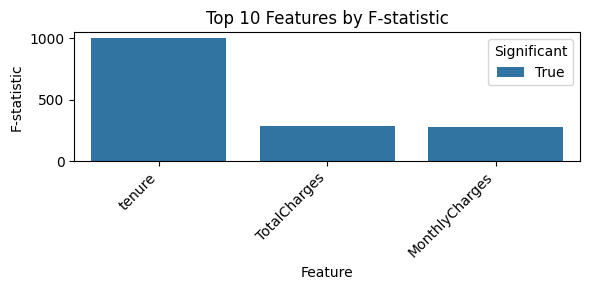

({'tenure': {'F-statistic': 997.2680104991438,
   'p-value': 7.999057960610892e-205},
  'TotalCharges': {'F-statistic': 288.2789610222117,
   'p-value': 2.127211613245422e-63},
  'MonthlyCharges': {'F-statistic': 273.4637042077133,
   'p-value': 2.7066456068950115e-60}},
 ['MonthlyCharges', 'TotalCharges', 'tenure'])

In [31]:
anova_feature_selection(df_cleaned, ['MonthlyCharges', 'TotalCharges', 'tenure'],'Churn')

#### Checking the linearity of Data

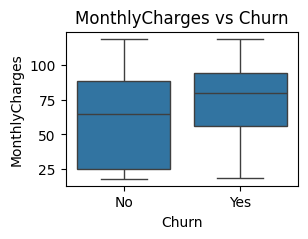

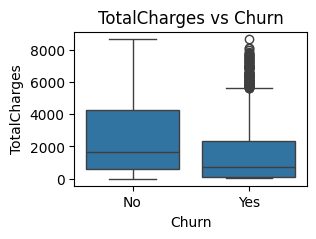

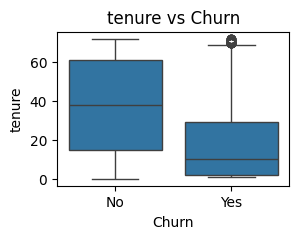

In [34]:
for col in ['MonthlyCharges', 'TotalCharges', 'tenure']:
    plt.figure(figsize=(3, 2))
    sns.boxplot(data=df_cleaned, x='Churn', y=col)
    plt.title(f'{col} vs Churn')
    plt.show()

In [36]:
def plot_binned_target(df, feature, target='Churn', bins=10, figsize=(8, 4)):
    df_temp = df.copy()
    df_temp['bin'] = pd.qcut(df_temp[feature], q=bins, duplicates='drop')
    grouped = df_temp.groupby('bin')[target].mean()
    
    plt.figure(figsize=figsize)
    grouped.plot(kind='line', marker='o')
    plt.title(f'{target} Rate vs Binned {feature}')
    plt.ylabel(f'Mean {target}')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

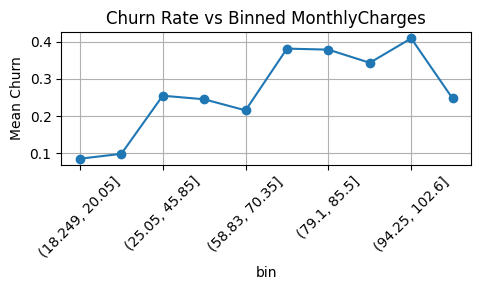

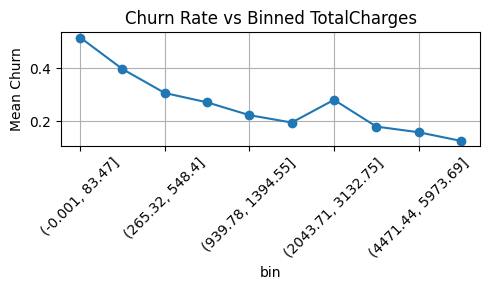

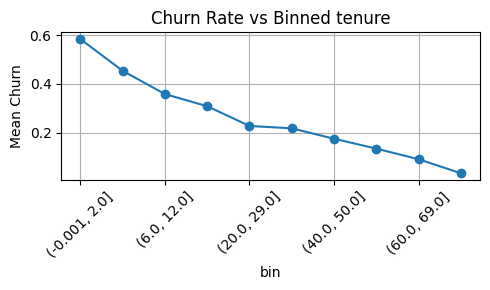

In [38]:
df_encoded_2 = df_cleaned.copy()
df_encoded_2['Churn'] = df_encoded_2['Churn'].map({'Yes': 1, 'No': 0})

for col in ['MonthlyCharges', 'TotalCharges', 'tenure']:
    plot_binned_target(df_encoded_2, col, figsize=(5, 3))

As a result of feature analysis, gender, PhoneService, MultipleLines, InternetService, StreamingTV, StreamingMovies seem to be irrelevant to Churn. All the continuous values are related to Churn.

### Feature Engineering
Developing new features based on the EDA and feature assessment results.<br/>
After that, going to assess the new features an decide which one to trim

In [42]:
df_cleaned.loc[(df_cleaned['tenure']>=0) & (df_cleaned['tenure']<=12),'new_tenure_year'] = '0-1 Year'
df_cleaned.loc[(df_cleaned['tenure']>12) & (df_cleaned['tenure']<=24),'new_tenure_year'] = '1-2 Year'
df_cleaned.loc[(df_cleaned['tenure']>24) & (df_cleaned['tenure']<=36),'new_tenure_year'] = '2-3 Year'
df_cleaned.loc[(df_cleaned['tenure']>36) & (df_cleaned['tenure']<=48),'new_tenure_year'] = '3-4 Year'
df_cleaned.loc[(df_cleaned['tenure']>48) & (df_cleaned['tenure']<=60),'new_tenure_year'] = '4-5 Year'
df_cleaned.loc[(df_cleaned['tenure']>60) & (df_cleaned['tenure']<=72),'new_tenure_year'] = '5-6 Year'

In [44]:
# New Features:
security_features = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']
df_cleaned['new_available_security'] = df_cleaned.apply(lambda x: 1 if (x["OnlineSecurity"] != "Yes") or (x["OnlineBackup"] != "Yes") or 
                                              (x["DeviceProtection"] != "Yes") or 
                                              (x["TechSupport"] != "Yes") else 0, axis=1)

df_cleaned['new_num_of_security'] = df_cleaned[security_features].apply(lambda row: (row == 'Yes').sum(), axis=1)

df_cleaned['new_any_streamingserivces'] = df_cleaned.apply(lambda x: 1 if (x["StreamingTV"] == "Yes") or 
                                           (x["StreamingMovies"] == "Yes") else 0, axis=1)

df_cleaned['new_independent_household'] = df_cleaned.apply(lambda x: 1 if (x['Partner'] == "No") and 
                                           (x['Dependents'] == "No") else 0, axis=1)

df_cleaned['new_engaged_contract'] = df_cleaned.apply(lambda x: 1 if (x['Contract'] in ["One year", 'Two year']) else 0, axis=1)

df_cleaned['new_electronic_payment'] = df_cleaned["PaymentMethod"].apply(lambda x: 1 if x in ["Electronic check"] else 0)

df_cleaned['new_automatic_payment'] = df_cleaned["PaymentMethod"].apply(lambda x: 1 if x in ["Bank transfer (automatic)","Credit card (automatic)"] else 0)

In [46]:
df_cleaned['new_num_of_services'] = (df_cleaned[['PhoneService', 'InternetService', 'OnlineSecurity',
                                       'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                       'StreamingTV', 'StreamingMovies']]== 'Yes').sum(axis=1)

df_cleaned['new_avg_changes'] = df_cleaned['TotalCharges'] / (df_cleaned['tenure'] + 1)

df_cleaned['new_increase'] = df_cleaned['new_avg_changes'] / df_cleaned['MonthlyCharges']

df_cleaned['new_avg_service_fee'] = df_cleaned['new_avg_changes'] / (df_cleaned['new_num_of_services'] + 1)

In [48]:
#high_monthly_charges > 89.85
#df['new_high_monthly_charges_with_engaged'] = df.apply(lambda x: 1 if (x['new_engaged_contract'] == 1) and 
                                                       #(x['new_engaged_contract'] == high_monthly_charges)else 0, axis=1)
df_cleaned['new_high_monthly_charges_with_engaged'] = df_cleaned.apply(
    lambda x: 1 if (x['new_engaged_contract'] == 1) and (x['MonthlyCharges'] > 89.85) else 0,
    axis=1)
# Define the bins and corresponding labels
bins = [18.25, 35.5, 70.35, 89.85, 118.75]
labels = ['low', 'medium', 'medium_high', 'high']

# Create the new feature
df_cleaned['monthly_charge_category'] = pd.cut(df_cleaned['MonthlyCharges'], bins=bins, labels=labels, include_lowest=True)

In [50]:
df_cleaned.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,new_tenure_year,new_available_security,new_num_of_security,new_any_streamingserivces,new_independent_household,new_engaged_contract,new_electronic_payment,new_automatic_payment,new_num_of_services,new_avg_changes,new_increase,new_avg_service_fee,new_high_monthly_charges_with_engaged,monthly_charge_category
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0-1 Year,1,1,0,0,0,1,0,1,14.925000,0.500000,7.462500,0,low
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,2-3 Year,1,2,0,1,1,0,0,3,53.985714,0.947949,13.496429,0,medium
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0-1 Year,1,2,0,1,0,0,0,3,36.050000,0.669452,9.012500,0,medium
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,3-4 Year,1,3,0,1,1,0,1,3,40.016304,0.946012,10.004076,0,medium
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0-1 Year,1,0,0,1,0,1,0,1,50.550000,0.714993,25.275000,0,medium_high


In [52]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 34 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   gender                                 7043 non-null   object  
 1   SeniorCitizen                          7043 non-null   int64   
 2   Partner                                7043 non-null   object  
 3   Dependents                             7043 non-null   object  
 4   tenure                                 7043 non-null   int64   
 5   PhoneService                           7043 non-null   object  
 6   MultipleLines                          7043 non-null   object  
 7   InternetService                        7043 non-null   object  
 8   OnlineSecurity                         7043 non-null   object  
 9   OnlineBackup                           7043 non-null   object  
 10  DeviceProtection                       7043 non-null   objec

#### Check the correlation among features including new ones using Chi-square analysis and correlation 

Chi-Square Test Results between Churn and Categorical Features:
                                  Feature   Chi-Square        P-Value  \
13                               Contract  1184.596572  5.863038e-258   
21                   new_engaged_contract  1153.971661  6.147586e-253   
16                        new_tenure_year   873.857760  1.209674e-186   
7                          OnlineSecurity   849.998968  2.661150e-185   
10                            TechSupport   828.197068  1.443084e-180   
6                         InternetService   732.309590  9.571788e-160   
22                 new_electronic_payment   640.557084  2.528030e-141   
15                          PaymentMethod   648.142327  3.682355e-140   
8                            OnlineBackup   601.812790  2.079759e-131   
9                        DeviceProtection   558.419369  5.505219e-122   
12                        StreamingMovies   375.661479   2.667757e-82   
11                            StreamingTV   374.203943   5.5

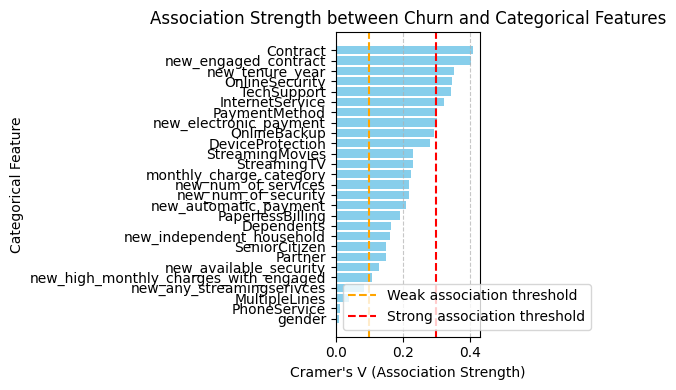

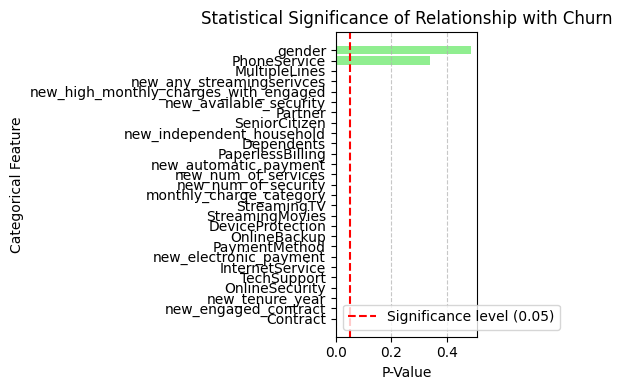


Categorical features significantly associated with Churn (p-value < 0.05):
                                  Feature        P-Value  Cramer's V
13                               Contract  5.863038e-258    0.410116
21                   new_engaged_contract  6.147586e-253    0.404780
16                        new_tenure_year  1.209674e-186    0.352242
7                          OnlineSecurity  2.661150e-185    0.347400
10                            TechSupport  1.443084e-180    0.342916
6                         InternetService  9.571788e-160    0.322455
22                 new_electronic_payment  2.528030e-141    0.301578
15                          PaymentMethod  3.682355e-140    0.303359
8                            OnlineBackup  2.079759e-131    0.292316
9                        DeviceProtection  5.505219e-122    0.281580
12                        StreamingMovies   2.667757e-82    0.230951
11                            StreamingTV   5.528994e-82    0.230502
26                monthly_c

In [55]:
from scipy.stats import chi2_contingency

# Select categorical columns
categorical_features = [
    col for col in df_cleaned.columns
    if df_cleaned[col].nunique() <= 10 and df_cleaned[col].dtype in ['object', 'category', 'int64']
]


# Run chi-square test with Churn
chi_square_results = chi_square_with_churn(df_cleaned, categorical_features, churn_col='Churn')

# Sort by chi sq results to find the strongest associations
cramers_sorted = chi_square_results.sort_values("Cramer's V", ascending=True)

# Sort by p-value to find the strongest associations
chi_square_results = chi_square_results.sort_values('P-Value')

# Display results
print("Chi-Square Test Results between Churn and Categorical Features:")
print(chi_square_results)

# Visualize results
plt.figure(figsize=(5, 4))
plt.barh(cramers_sorted['Feature'], cramers_sorted['Cramer\'s V'], color='skyblue')
plt.axvline(x=0.1, color='orange', linestyle='--', label='Weak association threshold')
plt.axvline(x=0.3, color='red', linestyle='--', label='Strong association threshold')
plt.xlabel('Cramer\'s V (Association Strength)')
plt.ylabel('Categorical Feature')
plt.title('Association Strength between Churn and Categorical Features')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Another visualization for p-values
plt.figure(figsize=(5, 4))
plt.barh(chi_square_results['Feature'], chi_square_results['P-Value'], color='lightgreen')
plt.axvline(x=0.05, color='red', linestyle='--', label='Significance level (0.05)')
plt.xlabel('P-Value')
plt.ylabel('Categorical Feature')
plt.title('Statistical Significance of Relationship with Churn')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Identify statistically significant features
significant_features = chi_square_results[chi_square_results['P-Value'] < 0.05]
print("\nCategorical features significantly associated with Churn (p-value < 0.05):")
print(significant_features[['Feature', 'P-Value', 'Cramer\'s V']])

ANOVA Results (alpha=0.05):
               Feature  F-statistic        p-value  Significant
0               tenure   997.268010  7.999058e-205         True
1         new_increase   780.794930  4.890756e-163         True
2  new_avg_service_fee   431.363619   4.833298e-93         True
3         TotalCharges   288.278961   2.127212e-63         True
4       MonthlyCharges   273.463704   2.706646e-60         True
5      new_avg_changes    37.286259   1.074238e-09         True

Number of significant features: 6


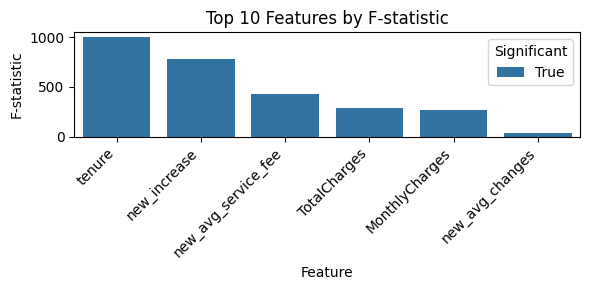

({'tenure': {'F-statistic': 997.2680104991438,
   'p-value': 7.999057960610892e-205},
  'new_increase': {'F-statistic': 780.7949298939279,
   'p-value': 4.890756003432915e-163},
  'new_avg_service_fee': {'F-statistic': 431.3636193323888,
   'p-value': 4.833297761946175e-93},
  'TotalCharges': {'F-statistic': 288.2789610222117,
   'p-value': 2.127211613245422e-63},
  'MonthlyCharges': {'F-statistic': 273.4637042077133,
   'p-value': 2.7066456068950115e-60},
  'new_avg_changes': {'F-statistic': 37.28625913193431,
   'p-value': 1.0742377759795302e-09}},
 ['MonthlyCharges',
  'TotalCharges',
  'tenure',
  'new_avg_changes',
  'new_increase',
  'new_avg_service_fee'])

In [57]:
anova_feature_selection(df_cleaned, ['MonthlyCharges', 'TotalCharges', 'tenure', 'new_avg_changes','new_increase','new_avg_service_fee'],'Churn')

In [59]:
# create df_encoded for corr matrix
from sklearn.preprocessing import LabelEncoder

# Copy the original dataframe to keep it safe
df_encoded = df_cleaned.copy()

# Get the list of non-numeric (text) columns
text_data_features = [col for col in df_encoded.columns if col not in df_encoded.describe().columns]

# Apply LabelEncoder to each text column
le = LabelEncoder()
print('Label Encoder Transformation')
for col in text_data_features:
    df_encoded[col] = le.fit_transform(df_encoded[col])
    print(f'{col} : {df_encoded[col].unique()} = {le.inverse_transform(df_encoded[col].unique())}')

Label Encoder Transformation
gender : [0 1] = ['Female' 'Male']
Partner : [1 0] = ['Yes' 'No']
Dependents : [0 1] = ['No' 'Yes']
PhoneService : [0 1] = ['No' 'Yes']
MultipleLines : [1 0 2] = ['No phone service' 'No' 'Yes']
InternetService : [0 1 2] = ['DSL' 'Fiber optic' 'No']
OnlineSecurity : [0 2 1] = ['No' 'Yes' 'No internet service']
OnlineBackup : [2 0 1] = ['Yes' 'No' 'No internet service']
DeviceProtection : [0 2 1] = ['No' 'Yes' 'No internet service']
TechSupport : [0 2 1] = ['No' 'Yes' 'No internet service']
StreamingTV : [0 2 1] = ['No' 'Yes' 'No internet service']
StreamingMovies : [0 2 1] = ['No' 'Yes' 'No internet service']
Contract : [0 1 2] = ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : [1 0] = ['Yes' 'No']
PaymentMethod : [2 3 0 1] = ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn : [0 1] = ['No' 'Yes']
new_tenure_year : [0 2 3 1 5 4] = ['0-1 Year' '2-3 Year' '3-4 Year' '1-2 Year' '5-6 Year' '4-5 Year']
mon

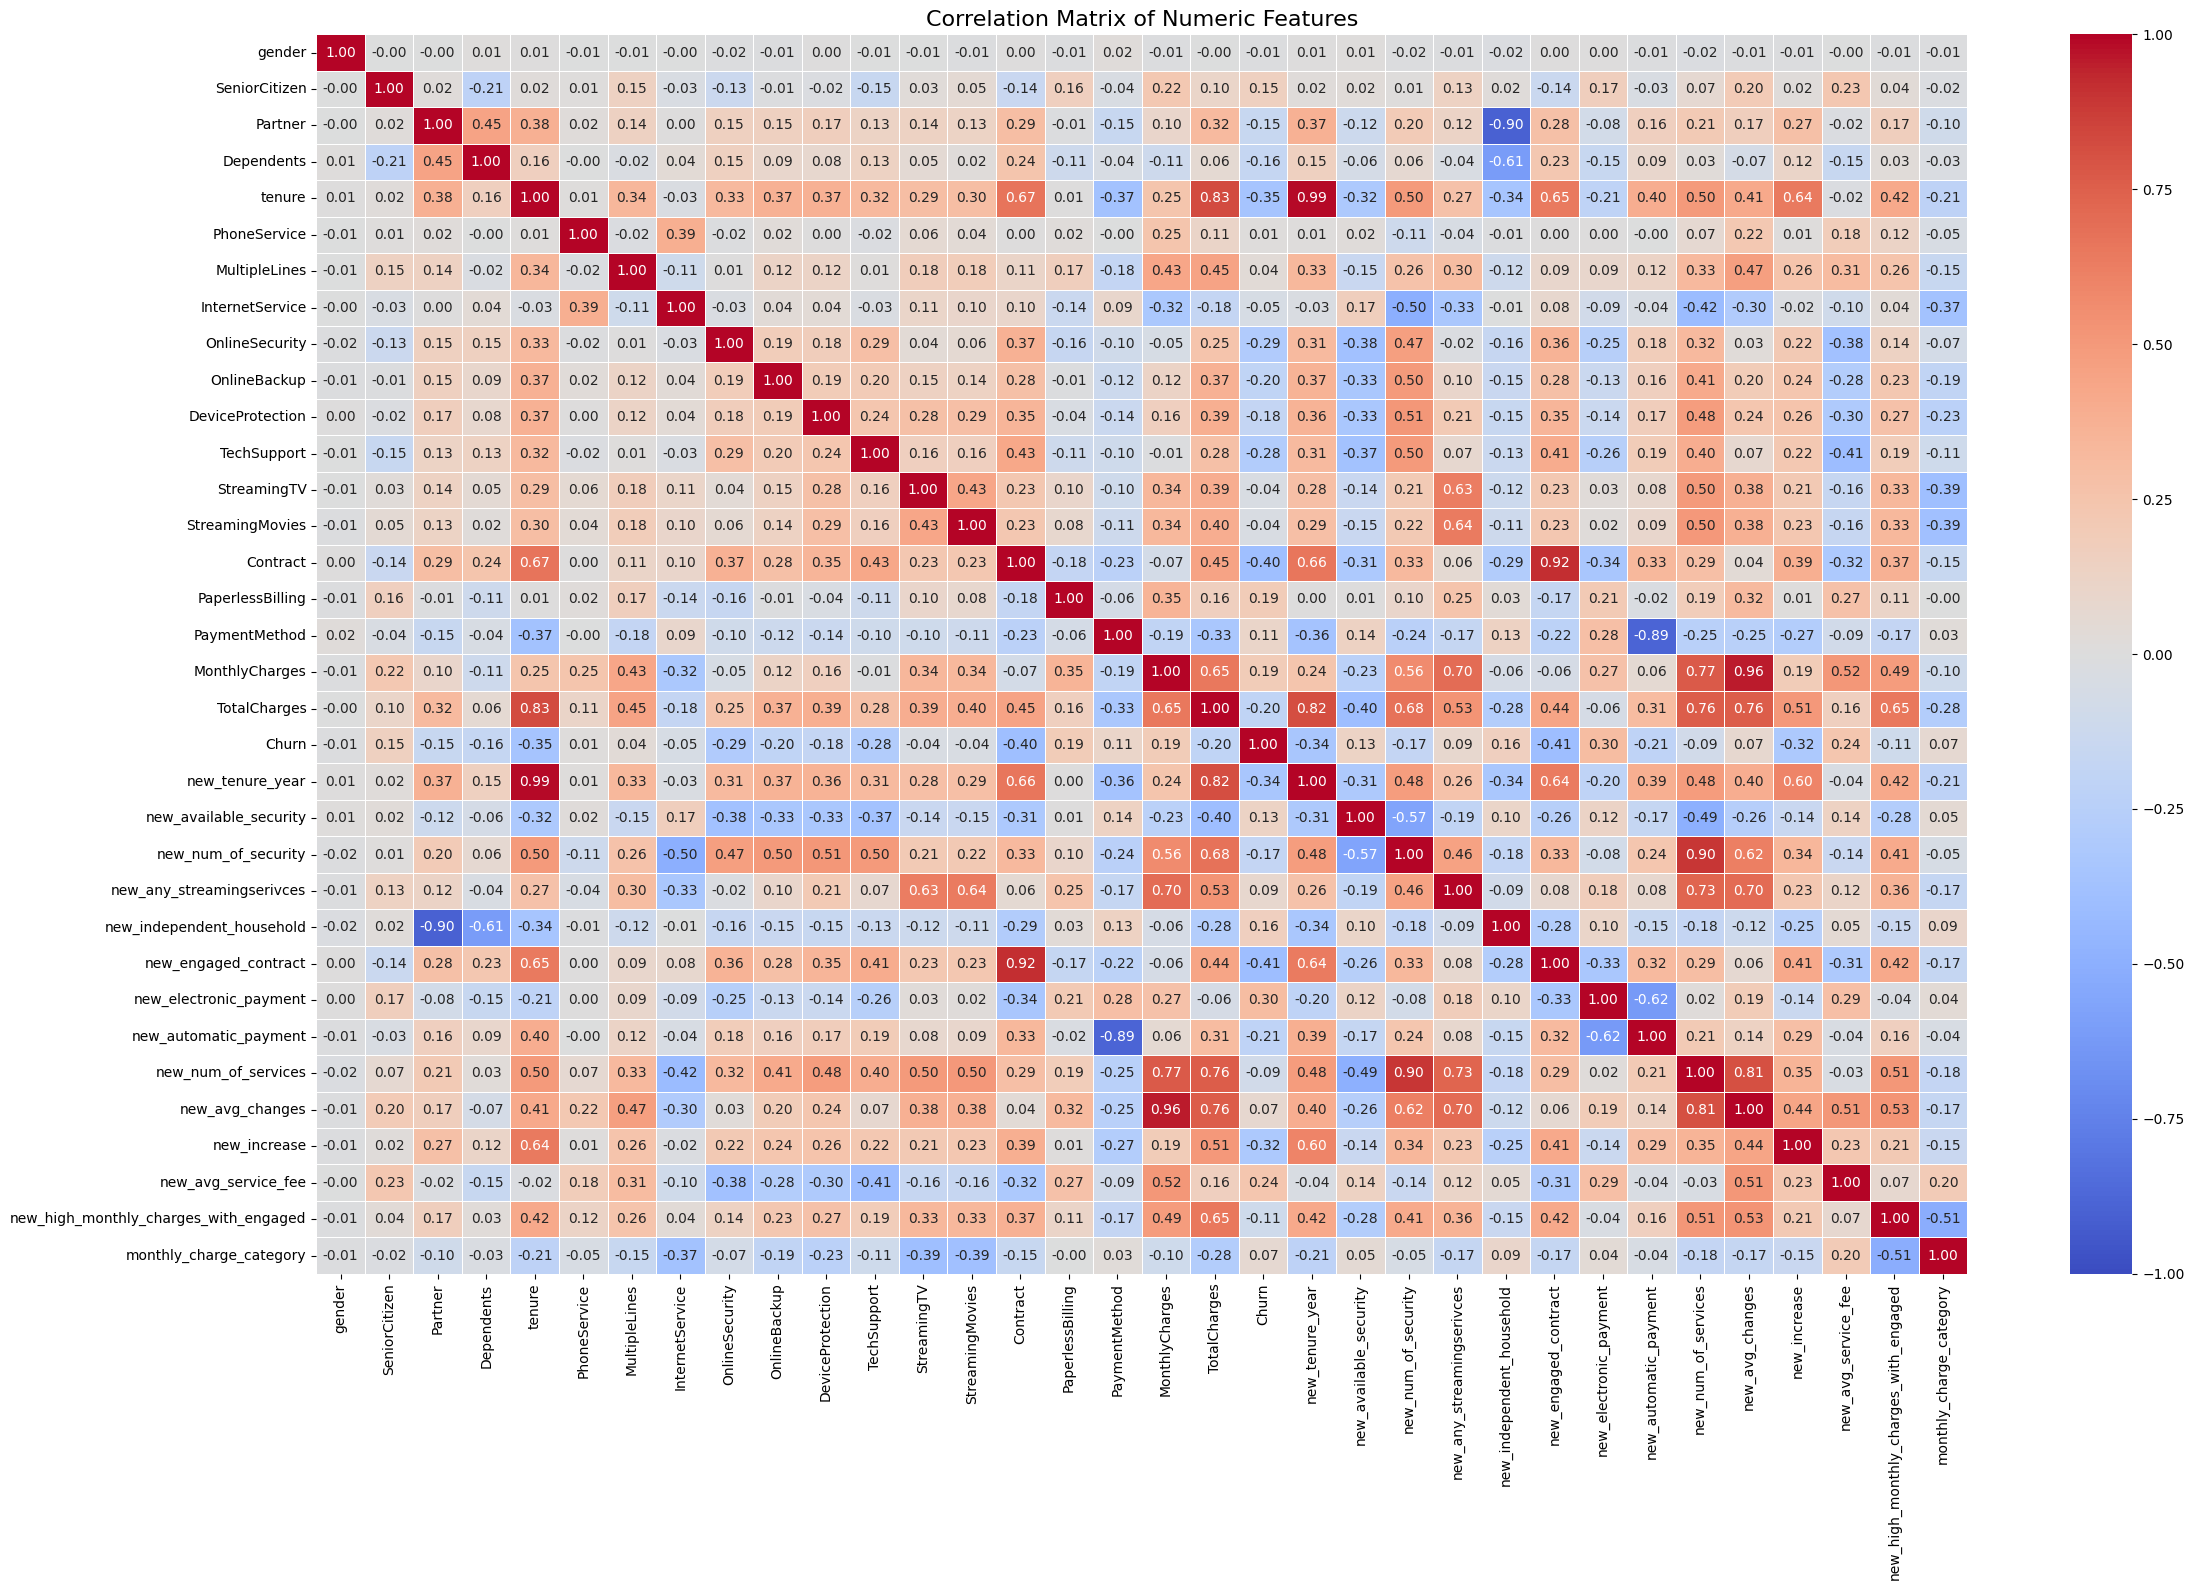

In [61]:
# calculate correlation matrix
correlation_matrix_all = df_encoded.corr()

# create a heatmap
plt.figure(figsize=(24, 16))
sns.heatmap(correlation_matrix_all, annot=True, cmap='coolwarm', fmt='.2f',
            linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numeric Features', fontsize=16)
plt.tight_layout()
plt.show()

#### As a result of correlation analysis, I decided to drop the following features:
**retain** = 'new_engaged_contract', 'new_increase'<br/>
**drop** = 'monthly_charge_category', ,'new_independent_household', 'new_any_streamingserivces', 'new_avg_changes','new_available_security','new_electronic_payment','new_avg_changes','new_high_monthly_charges_with_engaged','gender', 'PhoneService', 'MultipleLines', 'InternetService', 'StreamingTV', 'StreamingMovies'<br/>
<br/>
Dropping these features because:
- they have low correlation (between -0.1 and 0.1) between Churn or
- has low Chi-square or ANOVA test results or
- has too high correlation between other features (multicollinearity) -  'new_engaged_contract'

In [64]:
df_cleaned.drop(columns=[
    'monthly_charge_category',
    'new_independent_household',
    'new_any_streamingserivces',
    'new_available_security',
    'new_electronic_payment',
    'new_avg_changes',
    'new_high_monthly_charges_with_engaged',
    'gender',
    'PhoneService',
    'MultipleLines',
    'InternetService',
    'StreamingTV',
    'StreamingMovies'
], inplace=True)

In [66]:
df_cleaned.drop(columns=['new_engaged_contract'], inplace=True)

In [68]:
df_cleaned.head()

,SeniorCitizen,Partner,Dependents,tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,new_tenure_year,new_num_of_security,new_automatic_payment,new_num_of_services,new_increase,new_avg_service_fee
0,0,Yes,No,1,No,Yes,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0-1 Year,1,0,1,0.500000,7.462500
1,0,No,No,34,Yes,No,Yes,No,One year,No,Mailed check,56.95,1889.50,No,2-3 Year,2,0,3,0.947949,13.496429
2,0,No,No,2,Yes,Yes,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0-1 Year,2,0,3,0.669452,9.012500
3,0,No,No,45,Yes,No,Yes,Yes,One year,No,Bank transfer (automatic),42.30,1840.75,No,3-4 Year,3,1,3,0.946012,10.004076
4,0,No,No,2,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0-1 Year,0,0,1,0.714993,25.275000


#### Feature encoding

In [70]:
# One-hot encoding the data
import pandas as pd

# Drop the target column to avoid encoding it
df_cleaned_wo_churn = df_cleaned.drop('Churn', axis=1)

# Identify categorical (non-numeric) columns
text_data_features = [i for i in df_cleaned_wo_churn.columns if i not in df_cleaned_wo_churn.describe().columns]

print('One-Hot Encoder Transformation')

# Apply one-hot encoding using pandas and convert booleans to integers
df_cleaned_wo_churn = pd.get_dummies(df_cleaned_wo_churn, columns=text_data_features, drop_first=False).astype(int)

print(f"Columns after one-hot encoding: {df_cleaned_wo_churn.columns.tolist()}")

One-Hot Encoder Transformation
Columns after one-hot encoding: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'new_num_of_security', 'new_automatic_payment', 'new_num_of_services', 'new_increase', 'new_avg_service_fee', 'Partner_No', 'Partner_Yes', 'Dependents_No', 'Dependents_Yes', 'OnlineSecurity_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_No', 'PaperlessBilling_Yes', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'new_tenure_year_0-1 Year', 'new_tenure_year_1-2 Year', 'new_tenure_year_2-3 Year', 'new_tenure_year_3-4 Year', 'new_tenur

In [72]:
# Convert 'Churn' column from 'yes'/'no' to 1/0 using lambda
df_cleaned['Churn'] = df_cleaned['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Confirm the conversion
df_cleaned['Churn'].value_counts()

Churn
0    5174
1    1869
Name: count, dtype: int64

#### Feature Scaling
As a result of checking the linearity of continuous features in the previous section and after several trials, I decided not to use feature scaling this time.

### Train/Test/Validation Split

In [76]:
# split train-test-validation data
from sklearn.model_selection import train_test_split

# 1. Separate features and target
X = df_cleaned_wo_churn
y = df_cleaned['Churn']

# 2. First split: Train + Temp (80%) and Test (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Second split: Train (60%) and Validation (20%) from Train+Val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42
)
# (0.25 x 0.8 = 0.20 => 60% train, 20% val, 20% test)

# 4. Print shapes to verify
print("Train set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

# 5. Optional: Check class balance
print("\nChurn Distribution:")
print("Train:", y_train.value_counts(normalize=True).round(2))
print("Validation:", y_val.value_counts(normalize=True).round(2))
print("Test:", y_test.value_counts(normalize=True).round(2))

Train set shape: (4225, 40)
Validation set shape: (1409, 40)
Test set shape: (1409, 40)

Churn Distribution:
Train: Churn
0    0.73
1    0.27
Name: proportion, dtype: float64
Validation: Churn
0    0.73
1    0.27
Name: proportion, dtype: float64
Test: Churn
0    0.73
1    0.27
Name: proportion, dtype: float64


In [78]:
X_train.shape

(4225, 40)

### Handling Class Imbalance
I' going to use SMOTE as the oversampling method.

### Modeling and Baseline

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import numpy as np

# Step 1: Apply SMOTE on the training set only
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Original training class distribution:\n{np.bincount(y_train)}")
print(f"Resampled training class distribution (SMOTE):\n{np.bincount(y_train_smote)}")

# Step 2: Train logistic regression on the SMOTE-resampled data
smote_model = LogisticRegression(max_iter=1000, random_state=42)
smote_model.fit(X_train_smote, y_train_smote)

# Step 3: Make predictions on the validation set
y_pred = smote_model.predict(X_val)
y_prob = smote_model.predict_proba(X_val)[:, 1]

# Step 4: Evaluate performance on the validation set
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_prob)

# Step 5: Display metrics
print(f"\nSMOTE + Logistic Regression Performance:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

Original training class distribution:
[3104 1121]
Resampled training class distribution (SMOTE):
[3104 3104]

SMOTE + Logistic Regression Performance:
Accuracy:  0.8027
Precision: 0.6364
Recall:    0.5989
F1 Score:  0.6171
ROC AUC:   0.8329


### Hyperparameter Tuning & Model Comparison


Tuning and training Logistic Regression...
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

Best params for Logistic Regression: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression - Accuracy: 0.8126, Precision: 0.6618, Recall: 0.6016, F1: 0.6303, AUC: 0.8374

Tuning and training Random Forest...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best params for Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Random Forest - Accuracy: 0.7885, Precision: 0.6098, Recall: 0.5642, F1: 0.5861, AUC: 0.8162

Tuning and training XGBoost...
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best params for XGBoost: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}
XGBoost - Accuracy: 0.7892, Precision: 0.6066, Recall: 0.5856, F1: 0.5959, AUC: 0.8280

Tuning and training AdaBoost...
AdaBoost - Accuracy: 0.7878, Precision: 0.5921, Recall: 0.6444, F1: 0.6172, AUC: 0.8346


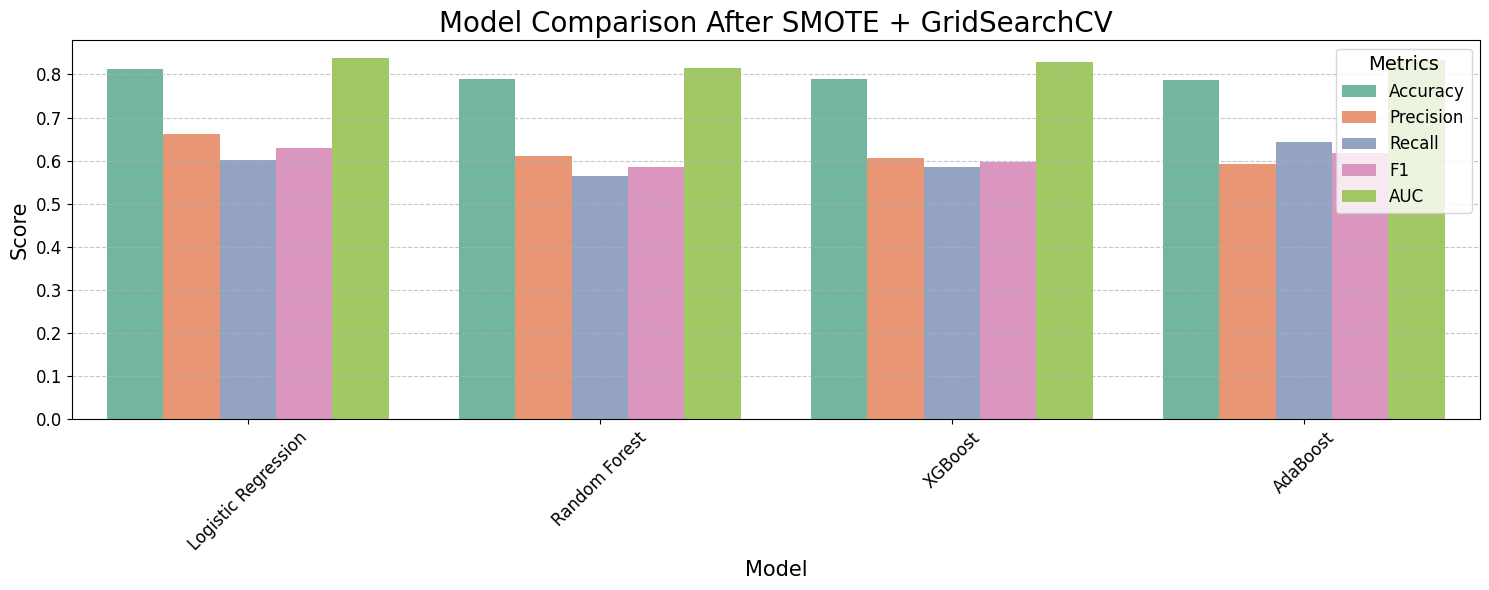


Best performing model after GridSearch + SMOTE: Logistic Regression


In [82]:
# without feature scaling
## only including relevant new_ features
# SMOTE+Robustscaler+one-hot+dropped low corr+ multi corr features
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore', message='.*use_label_encoder.*')

# Step 1: Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Step 2: Define models and parameter grids
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, verbosity=0), 
    'AdaBoost': AdaBoostClassifier(random_state=42)  # Note: not included in grid search below
}

param_grids = {
    'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'XGBoost': {
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9]
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'kernel': ['rbf', 'linear', 'poly']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }
}

# Step 3: Initialize results storage
results = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1': [],
    'AUC': []
}

# Step 4: Grid search + training + evaluation
for name, model in models.items():
    print(f"\nTuning and training {name}...")
    
    if name in param_grids:
        grid_search = GridSearchCV(model, param_grids[name], cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
        grid_search.fit(X_train_smote, y_train_smote)
        best_model = grid_search.best_estimator_
        print(f"Best params for {name}: {grid_search.best_params_}")
    else:
        best_model = model
        best_model.fit(X_train_smote, y_train_smote)
    
    # Predict and evaluate
    y_pred = best_model.predict(X_val)
    y_prob = best_model.predict_proba(X_val)[:, 1]
    
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)
    # auc = roc_auc_score(y_val, y_prob)
    results['Model'].append(name)
    results['Accuracy'].append(accuracy)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['F1'].append(f1)
    results['AUC'].append(auc)
    
    print(f"{name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

# Step 5: Create results DataFrame
results_df = pd.DataFrame(results)

# Step 6: Visualize results
plt.figure(figsize=(15, 6))
melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
sns.barplot(data=melted, x='Model', y='Score', hue='Metric', palette='Set2')
plt.title('Model Comparison After SMOTE + GridSearchCV', fontsize=20)
plt.xlabel('Model', fontsize=15)
plt.ylabel('Score', fontsize=15)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Metrics', fontsize=12, title_fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('model_comparison_gridsearch.png', bbox_inches='tight', dpi=300)
plt.show()

# Step 7: Identify best model based on AUC
best_model_name = results_df.loc[results_df['AUC'].idxmax(), 'Model']
print(f"\nBest performing model after GridSearch + SMOTE: {best_model_name}")

In [ ]:
### Without new_engaged_contract


Tuning and training Logistic Regression...
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

Best params for Logistic Regression: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression - Accuracy: 0.8126, Precision: 0.6618, Recall: 0.6016, F1: 0.6303, AUC: 0.8374

Tuning and training Random Forest...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best params for Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Random Forest - Accuracy: 0.7885, Precision: 0.6098, Recall: 0.5642, F1: 0.5861, AUC: 0.8162

Tuning and training XGBoost...
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best params for XGBoost: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}
XGBoost - Accuracy: 0.7892, Precision: 0.6066, Recall: 0.5856, F1: 0.5959, AUC: 0.8280

Tuning and training AdaBoost...
AdaBoost - Accuracy: 0.7878, Precision: 0.5921, Recall: 0.6444, F1: 0.6172, AUC: 0.8346


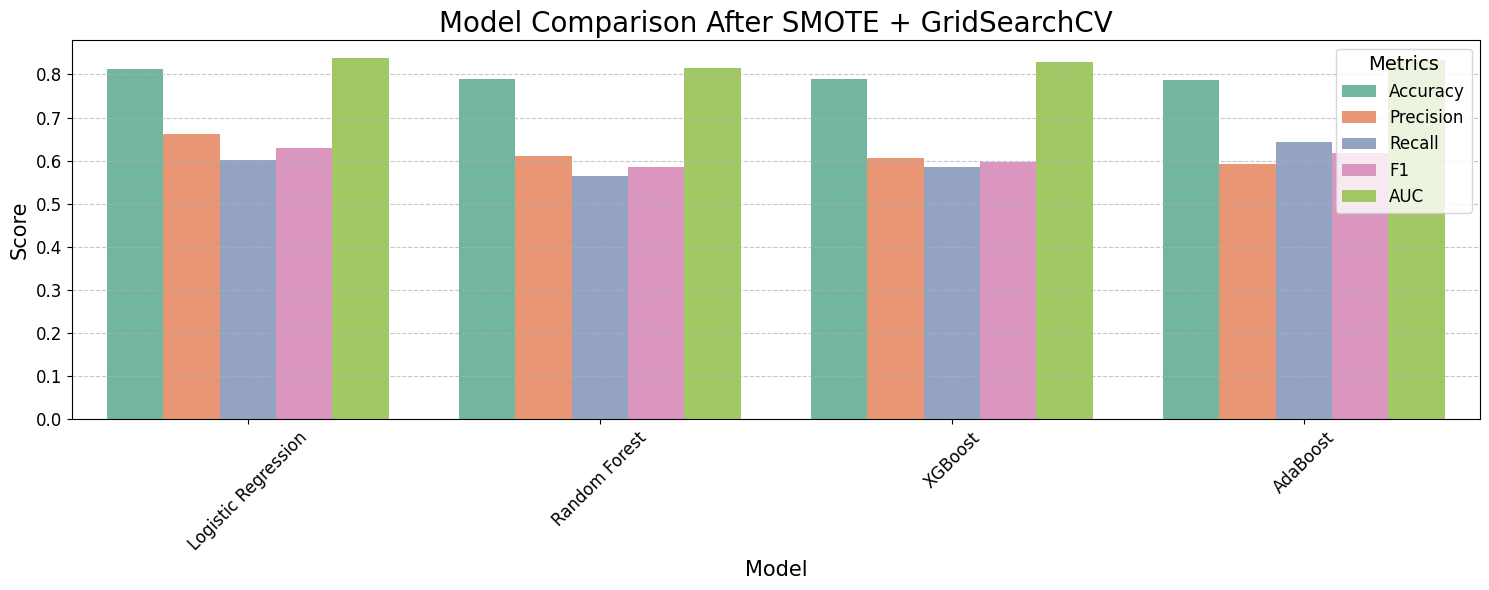


Best performing model after GridSearch + SMOTE: Logistic Regression


In [83]:
# without new_engaged_contract and new_increase
# without feature scaling
## only including relevant new_ features
# SMOTE+Robustscaler+one-hot+dropped low corr+ multi corr features
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore', message='.*use_label_encoder.*')

# Step 1: Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Step 2: Define models and parameter grids
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, verbosity=0), 
    'AdaBoost': AdaBoostClassifier(random_state=42)  # Note: not included in grid search below
}

param_grids = {
    'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'XGBoost': {
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9]
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'kernel': ['rbf', 'linear', 'poly']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }
}

# Step 3: Initialize results storage
results = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1': [],
    'AUC': []
}

# Step 4: Grid search + training + evaluation
for name, model in models.items():
    print(f"\nTuning and training {name}...")
    
    if name in param_grids:
        grid_search = GridSearchCV(model, param_grids[name], cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
        grid_search.fit(X_train_smote, y_train_smote)
        best_model = grid_search.best_estimator_
        print(f"Best params for {name}: {grid_search.best_params_}")
    else:
        best_model = model
        best_model.fit(X_train_smote, y_train_smote)
    
    # Predict and evaluate
    y_pred = best_model.predict(X_val)
    y_prob = best_model.predict_proba(X_val)[:, 1]
    
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)
    # auc = roc_auc_score(y_val, y_prob)
    results['Model'].append(name)
    results['Accuracy'].append(accuracy)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['F1'].append(f1)
    results['AUC'].append(auc)
    
    print(f"{name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

# Step 5: Create results DataFrame
results_df = pd.DataFrame(results)

# Step 6: Visualize results
plt.figure(figsize=(15, 6))
melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
sns.barplot(data=melted, x='Model', y='Score', hue='Metric', palette='Set2')
plt.title('Model Comparison After SMOTE + GridSearchCV', fontsize=20)
plt.xlabel('Model', fontsize=15)
plt.ylabel('Score', fontsize=15)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Metrics', fontsize=12, title_fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('model_comparison_gridsearch.png', bbox_inches='tight', dpi=300)
plt.show()

# Step 7: Identify best model based on AUC
best_model_name = results_df.loc[results_df['AUC'].idxmax(), 'Model']
print(f"\nBest performing model after GridSearch + SMOTE: {best_model_name}")

### Model Evaluation

In [97]:
from sklearn.metrics import classification_report

def plot_classification_report(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap='Blues', fmt='.2f')
    plt.title(f'Classification Report: {model_name}')
    plt.ylabel('Classes')
    plt.xlabel('Metrics')
    plt.tight_layout()
    plt.show()


Tuning and training Logistic Regression...
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

Best params for Logistic Regression: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression - Accuracy: 0.8126, Precision: 0.6618, Recall: 0.6016, F1: 0.6303, AUC: 0.8374


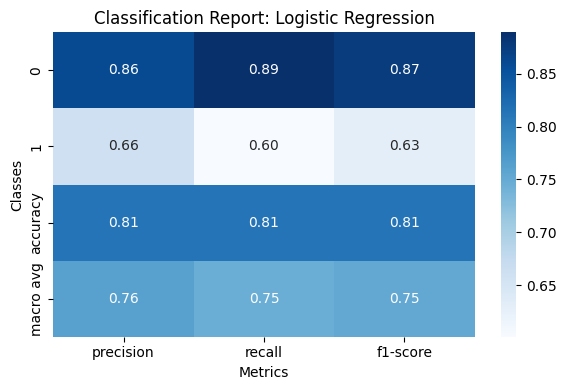


Tuning and training Random Forest...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best params for Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Random Forest - Accuracy: 0.7885, Precision: 0.6098, Recall: 0.5642, F1: 0.5861, AUC: 0.8162


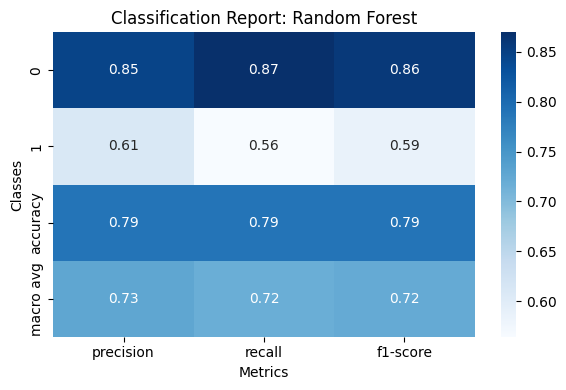


Tuning and training XGBoost...
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best params for XGBoost: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}
XGBoost - Accuracy: 0.7892, Precision: 0.6066, Recall: 0.5856, F1: 0.5959, AUC: 0.8280


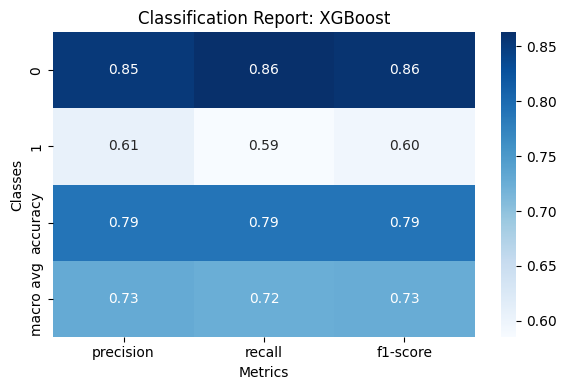


Tuning and training AdaBoost...
AdaBoost - Accuracy: 0.7878, Precision: 0.5921, Recall: 0.6444, F1: 0.6172, AUC: 0.8346


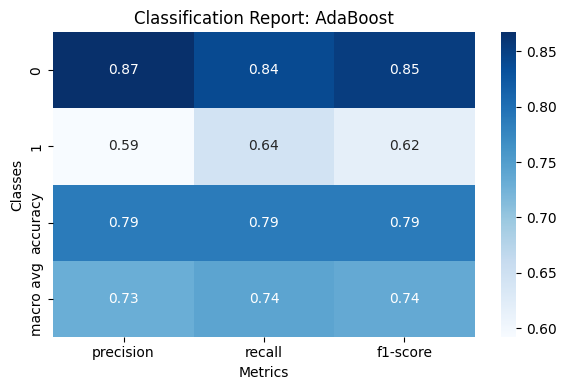

In [101]:
best_models = {}

for name, model in models.items():
    print(f"\nTuning and training {name}...")
    
    if name in param_grids:
        grid_search = GridSearchCV(model, param_grids[name], cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
        grid_search.fit(X_train_smote, y_train_smote)
        best_model = grid_search.best_estimator_
        print(f"Best params for {name}: {grid_search.best_params_}")
    else:
        best_model = model
        best_model.fit(X_train_smote, y_train_smote)
    
    best_models[name] = best_model  # Store for ROC plotting
    
    y_pred = best_model.predict(X_val)
    y_prob = best_model.predict_proba(X_val)[:, 1]
    
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc_score = roc_auc_score(y_val, y_prob)
    
    results['Model'].append(name)
    results['Accuracy'].append(accuracy)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['F1'].append(f1)
    results['AUC'].append(auc_score)
    
    print(f"{name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc_score:.4f}")
    
    plot_classification_report(y_val, y_pred, model_name=name)


In [99]:
from sklearn.metrics import roc_curve, auc

def plot_all_roc(models_dict, X_val, y_val):
    plt.figure(figsize=(8, 6))
    
    for name, model in models_dict.items():
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_val)[:, 1]
        else:
            y_prob = model.decision_function(X_val)  # for SVM with no predict_proba

        fpr, tpr, _ = roc_curve(y_val, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for All Models')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('roc_curves_all_models.png', bbox_inches='tight', dpi=300)
    plt.show()

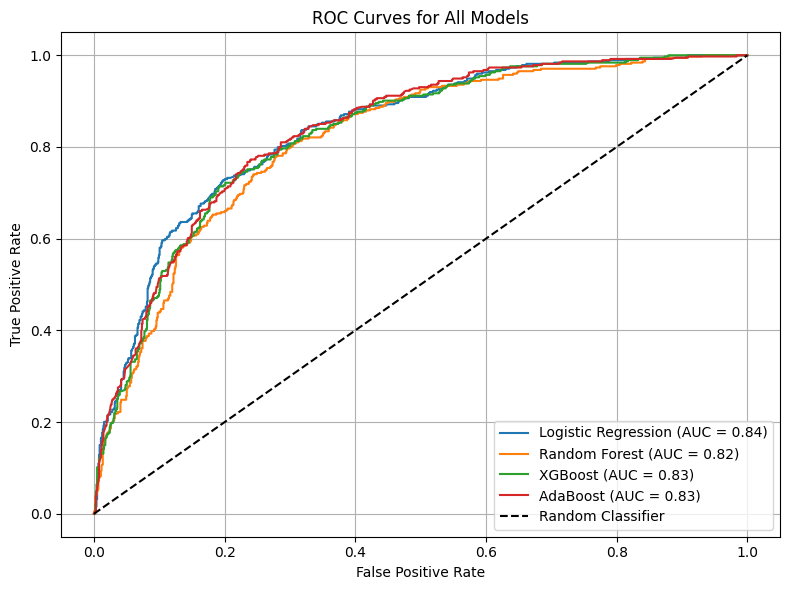

In [103]:
plot_all_roc(best_models, X_val, y_val)

**As a result of model comparison, it turned out that Logistic Rregression is performing the best with Accuracy = 0.81, F1 = 0.63, and AUC = 0.84**

### Feature Importance Analysis

#### Random Forest Feature Importance (without new_engaged_contract)

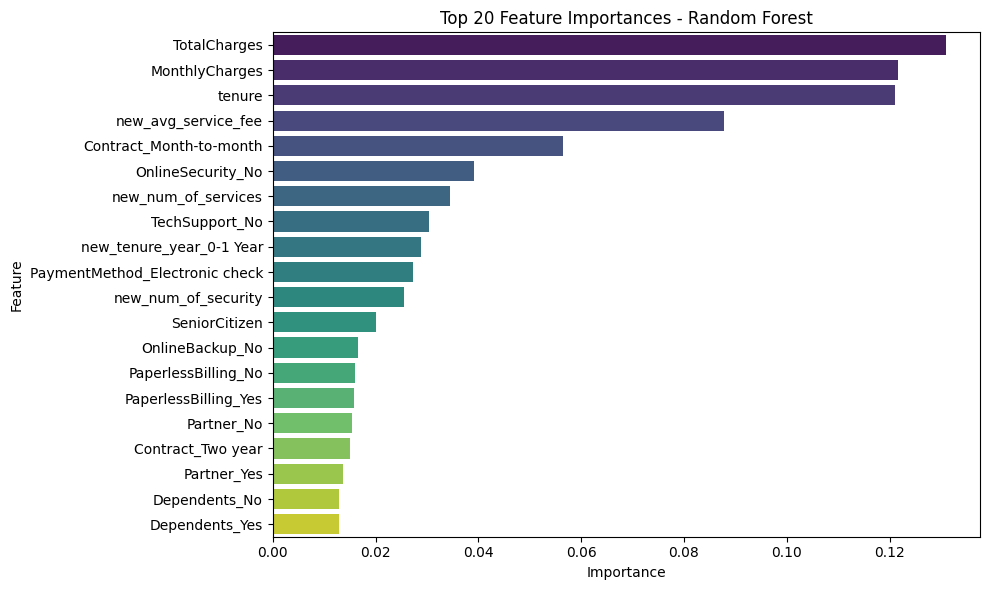

In [105]:
#Feature importance with no scaling
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Extract feature importances
rf_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=rf_importance.head(20), palette='viridis')
plt.title('Top 20 Feature Importances - Random Forest')
plt.tight_layout()
plt.show()

#### XGBoost Feature Importance

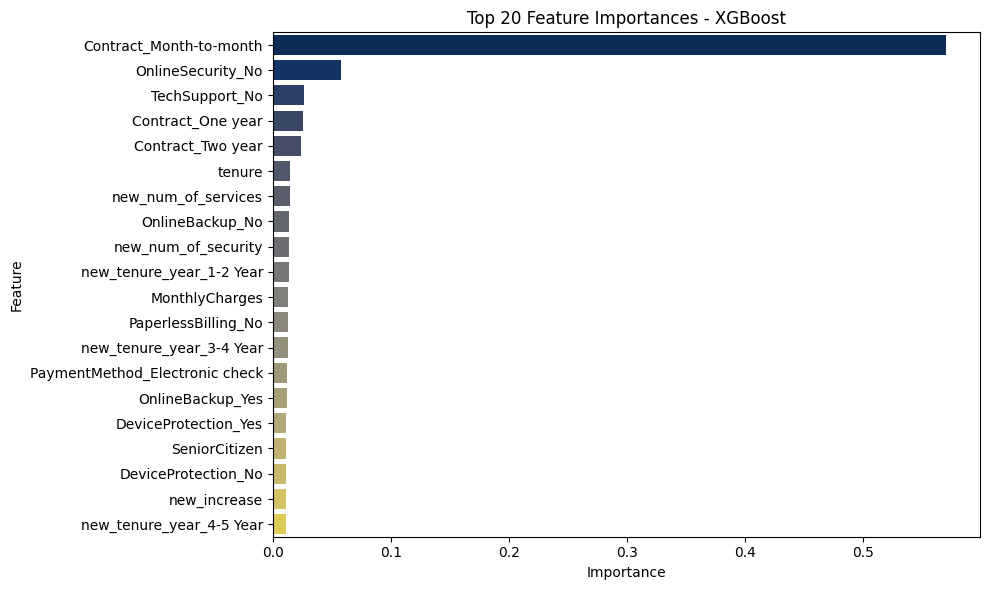

In [108]:
from xgboost import XGBClassifier

# Train XGBoost
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)

# Extract feature importances
xgb_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=xgb_importance.head(20), palette='cividis')
plt.title('Top 20 Feature Importances - XGBoost')
plt.tight_layout()
plt.show()


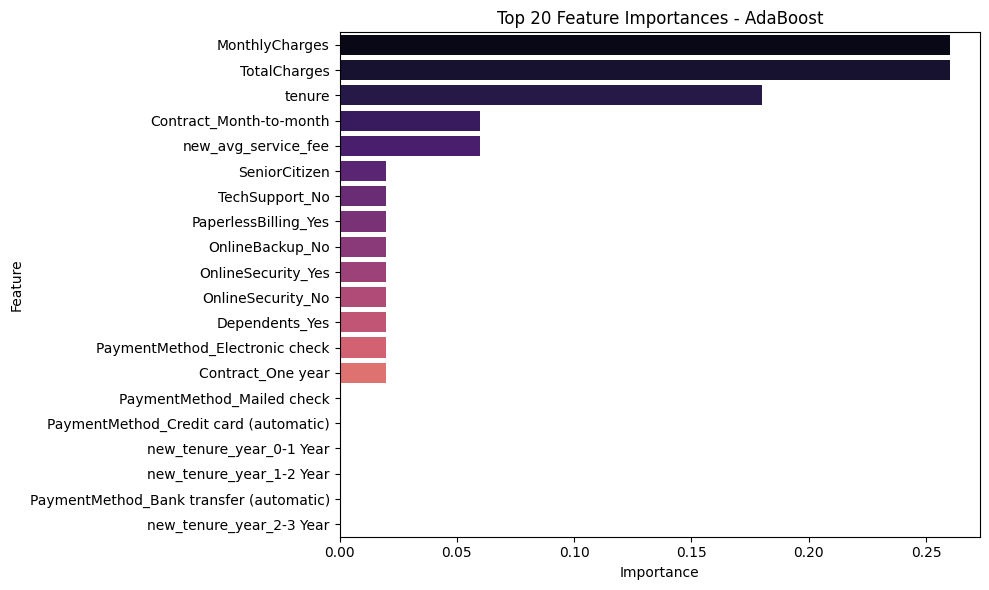

In [109]:
from sklearn.ensemble import AdaBoostClassifier

# Train AdaBoost
ada = AdaBoostClassifier(random_state=42)
ada.fit(X_train, y_train)

# Extract feature importances
ada_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': ada.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=ada_importance.head(20), palette='magma')
plt.title('Top 20 Feature Importances - AdaBoost')
plt.tight_layout()
plt.show()
